# Pre-2004 Wildfire Prediction Using ARIMAX
- We will use ARIMAX to predict the **number of wildfires per day** and the **average fire size** in California. The model will use environmental data such as **temperature** and **precipitation** to improve accuracy.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima

In [2]:
df = pd.read_csv('pre_2004_data.csv')
df

,DiscoveryDate,DiscoveryDayOfYear,DiscoveryTime,ContainmentDate,ContainmentDayOfYear,ContainmentTime,FireSize,FireSizeClass,Latitude,Longitude,CauseClassification,GeneralCause,MinTemperature,MaxTemperature,AvgTemperature,Precipitation,Snowfall
0,1992-01-01,1,01:30,1992-01-01,1.0,02:10,0.1,A,38.205000,-120.335000,Natural,Natural,3.89,13.89,8.89,0.00,0.0
1,1992-01-01,1,13:30,1992-01-01,1.0,17:00,5.0,B,33.166700,-116.634200,Human,Debris and open burning,-1.67,12.78,5.56,0.00,0.0
2,1992-01-01,1,14:37,1992-01-01,1.0,15:07,0.2,A,33.663889,-116.171944,Human,Misuse of fire by a minor,-1.67,12.78,5.56,0.00,0.0
3,1992-01-02,2,14:37,1992-01-02,2.0,15:07,0.2,A,33.030000,-116.831944,Human,Missing data/not specified/undetermined,-1.11,12.22,5.56,0.00,0.0
4,1992-01-02,2,14:37,1992-01-02,2.0,15:17,0.5,B,33.896111,-116.990000,Human,Missing data/not specified/undetermined,-1.11,12.22,5.56,0.00,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96831,2003-12-29,363,07:41,2003-12-29,363.0,08:00,0.1,A,34.140000,-117.150000,Human,Power generation/transmission/distribution,-1.67,9.44,3.89,0.00,0.0
96832,2003-12-29,363,21:40,2003-12-29,363.0,22:30,0.1,A,34.381944,-118.097222,Human,Arson/incendiarism,-1.67,9.44,3.89,0.00,0.0
96833,2003-12-31,365,15:58,2003-12-31,365.0,16:31,0.2,A,33.968056,-117.515000,Human,Equipment and vehicle use,0.56,12.78,6.67,0.00,0.0
96834,2003-12-31,365,16:53,2003-12-31,365.0,17:02,0.1,A,38.185000,-120.371389,Human,Debris and open burning,3.89,11.11,7.50,0.51,0.0


In [3]:
# Select relevant columns for  prediction
df_selected = df[['DiscoveryDate', 'FireSize', 'MaxTemperature']]
df_selected.head()

,DiscoveryDate,FireSize,MaxTemperature
0,1992-01-01,0.1,13.89
1,1992-01-01,5.0,12.78
2,1992-01-01,0.2,12.78
3,1992-01-02,0.2,12.22
4,1992-01-02,0.5,12.22


## Number of Wildfires per Day Prediction

In [4]:
# Group by DiscoveryDate and count the number of fires, average environmental factors
df_aggregated = df_selected.groupby('DiscoveryDate').agg({
    'FireSize': 'count', 
    'MaxTemperature': 'mean',  
}).rename(columns={'FireSize': 'NumberOfFires'})  

df_aggregated

,NumberOfFires,MaxTemperature
DiscoveryDate,,
1992-01-01,3,13.150000
1992-01-02,3,12.220000
1992-01-03,1,13.890000
1992-01-04,2,12.220000
1992-01-06,1,11.670000
...,...,...
2003-12-24,1,13.330000
2003-12-27,1,13.330000
2003-12-28,3,10.736667


#### Set the Frequency to Daily and Fill Missing Data

In [5]:
# Ensure DiscoveryDate has daily frequency
df_aggregated.index = pd.to_datetime(df_aggregated.index)
df_aggregated = df_aggregated.asfreq('D')

# Fill missing NumberOfFires with 0
df_aggregated['NumberOfFires'].fillna(0, inplace=True)

# Handle missing environmental variables with interpolation
df_aggregated['MaxTemperature'].interpolate(method='linear', inplace=True)

df_aggregated.head()

,NumberOfFires,MaxTemperature
DiscoveryDate,,
1992-01-01,3.0,13.150
1992-01-02,3.0,12.220
1992-01-03,1.0,13.890
1992-01-04,2.0,12.220
1992-01-05,0.0,11.945


In [6]:
# Define the target variable (number of fires per day)
y = df_aggregated['NumberOfFires']

# Define the exogenous variables (MaxTemperature)
X = df_aggregated[['MaxTemperature']]

y.head(), X.head()

(DiscoveryDate
 1992-01-01    3.0
 1992-01-02    3.0
 1992-01-03    1.0
 1992-01-04    2.0
 1992-01-05    0.0
 Freq: D, Name: NumberOfFires, dtype: float64,
                MaxTemperature
 DiscoveryDate                
 1992-01-01             13.150
 1992-01-02             12.220
 1992-01-03             13.890
 1992-01-04             12.220
 1992-01-05             11.945)

#### Check for Stationarity and Determine **d**

In [7]:
# Perform the ADF test on the target variable
adf_test = adfuller(df_aggregated['NumberOfFires'])

# Display the results
print(f'ADF Statistic: {adf_test[0]}')
print(f'p-value: {adf_test[1]}')

if adf_test[1] > 0.05:
    print("The data is non-stationary, and differencing is needed.")
else:
    print("The data is stationary, no differencing is needed.")

ADF Statistic: -4.412652157938259
p-value: 0.0002818970145479848
The data is stationary, no differencing is needed.


#### Determine **p** and **q** Using ACF and PACF Plots

Text(0.5, 1.0, 'PACF Plot')

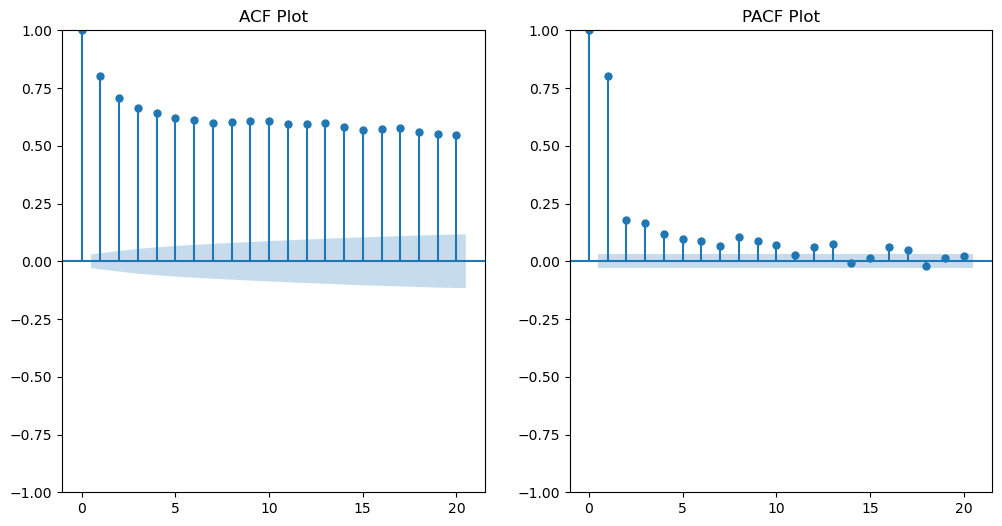

In [8]:
plt.figure(figsize=(12,6))

# Plot ACF (for q)
plt.subplot(121)
plot_acf(df_aggregated['NumberOfFires'], lags=20, ax=plt.gca())
plt.title('ACF Plot')

# PACF plot (for p)
plt.subplot(122)
plot_pacf(df_aggregated['NumberOfFires'], lags=20, ax=plt.gca())
plt.title('PACF Plot')

#### Manually determined ARIMAX parameters

In [9]:
p = 1  # From PACF plot
d = 0  # From ADF test
q = 2  # From ACF plot

#### Split the Data into Training and Testing Sets

In [10]:
len(df_aggregated)

4383

In [11]:
# Define the test size
test_size = 0.2

# Calculate the number of test samples
test_samples = int(len(df_aggregated) * test_size)

# Split the data
y_train = df_aggregated['NumberOfFires'][:-test_samples]
y_test = df_aggregated['NumberOfFires'][-test_samples:]

X_train = df_aggregated[['MaxTemperature']][:-test_samples]
X_test = df_aggregated[['MaxTemperature']][-test_samples:]

print(f'Training set size: {len(y_train)}')
print(f'Test set size: {len(y_test)}')

Training set size: 3507
Test set size: 876


In [12]:
y_train, y_test

(DiscoveryDate
 1992-01-01     3.0
 1992-01-02     3.0
 1992-01-03     1.0
 1992-01-04     2.0
 1992-01-05     0.0
               ... 
 2001-08-03    41.0
 2001-08-04    34.0
 2001-08-05    48.0
 2001-08-06    50.0
 2001-08-07    48.0
 Freq: D, Name: NumberOfFires, Length: 3507, dtype: float64,
 DiscoveryDate
 2001-08-08    149.0
 2001-08-09     87.0
 2001-08-10     44.0
 2001-08-11     26.0
 2001-08-12     47.0
               ...  
 2003-12-27      1.0
 2003-12-28      3.0
 2003-12-29      3.0
 2003-12-30      0.0
 2003-12-31      3.0
 Freq: D, Name: NumberOfFires, Length: 876, dtype: float64)

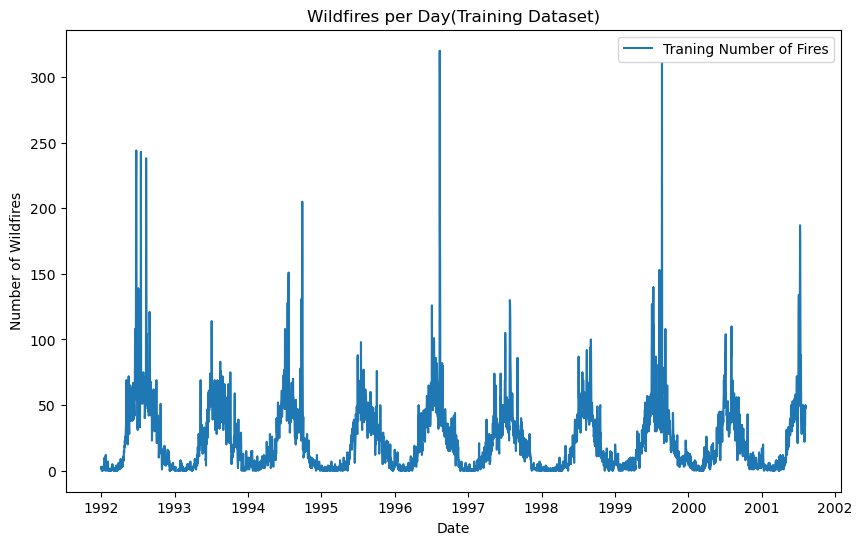

In [13]:
plt.figure(figsize=(10, 6))
plt.plot(y_train.index, y_train, label='Traning Number of Fires')
plt.title('Wildfires per Day(Training Dataset)')
plt.xlabel('Date')
plt.ylabel('Number of Wildfires')
plt.legend()

In [14]:
X_train, X_test

(               MaxTemperature
 DiscoveryDate                
 1992-01-01          13.150000
 1992-01-02          12.220000
 1992-01-03          13.890000
 1992-01-04          12.220000
 1992-01-05          11.945000
 ...                       ...
 2001-08-03          32.761951
 2001-08-04          33.725882
 2001-08-05          34.911875
 2001-08-06          35.264800
 2001-08-07          36.537292
 
 [3507 rows x 1 columns],
                MaxTemperature
 DiscoveryDate                
 2001-08-08          36.599060
 2001-08-09          35.324138
 2001-08-10          35.593864
 2001-08-11          33.675769
 2001-08-12          35.423617
 ...                       ...
 2003-12-27          13.330000
 2003-12-28          10.736667
 2003-12-29           9.440000
 2003-12-30          10.831667
 2003-12-31          12.223333
 
 [876 rows x 1 columns])

#### Fit the ARIMAX Model Using the Training Data

In [15]:
model = SARIMAX(y_train, exog=X_train, order=(p, d, q))

# Train the model
model_fit = model.fit()

# Summary of the model
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:          NumberOfFires   No. Observations:                 3507
Model:               SARIMAX(1, 0, 2)   Log Likelihood              -14214.313
Date:                Sat, 21 Sep 2024   AIC                          28438.626
Time:                        23:36:26   BIC                          28469.438
Sample:                    01-01-1992   HQIC                         28449.621
                         - 08-07-2001                                         
Covariance Type:                  opg                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
MaxTemperature     0.2114      0.090      2.342      0.019       0.034       0.388
ar.L1              0.9915      0.002    488.892      0.000       0.988       0.995
ma.L1             -0.4585      0.006    -76.438      0.000      -0.470      -0.447
ma.L2             -0.2897      0.008    -37.088      0.000      -0.305      -0.274
sigma2           193.9842      0.911    213.017      0.000     192.199     195.769
===================================================================================
Ljung-Box (L1) (Q):                   5.78   Jarque-Bera (JB):           1143134.24
Prob(Q):                              0.02   Prob(JB):                         0.00
Heteroskedasticity (H):               0.85   Skew:                             5.76
Prob(H) (two-sided):                  0.01   Kurtosis:                        90.69
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

#### Make Predictions on the Test Data

In [16]:
# Make predictions on the test data
predictions = model_fit.predict(start=len(y_train), end=len(y_train) + len(y_test) - 1, exog=X_test)

# Calculate the RMSE (Root Mean Squared Error)
rmse = mean_squared_error(y_test, predictions, squared=False)
print(f'Root Mean Squared Error (RMSE): {rmse}')

Root Mean Squared Error (RMSE): 27.381726274904477


In [17]:
# Calculate the Normalized RMSE as a percentage of the mean
mean_fires = y_test.mean()
std_fires = y_test.std()
nrmse = (rmse / mean_fires) * 100
print(f"Normalized RMSE: {nrmse:.2f}%")

Normalized RMSE: 133.10%


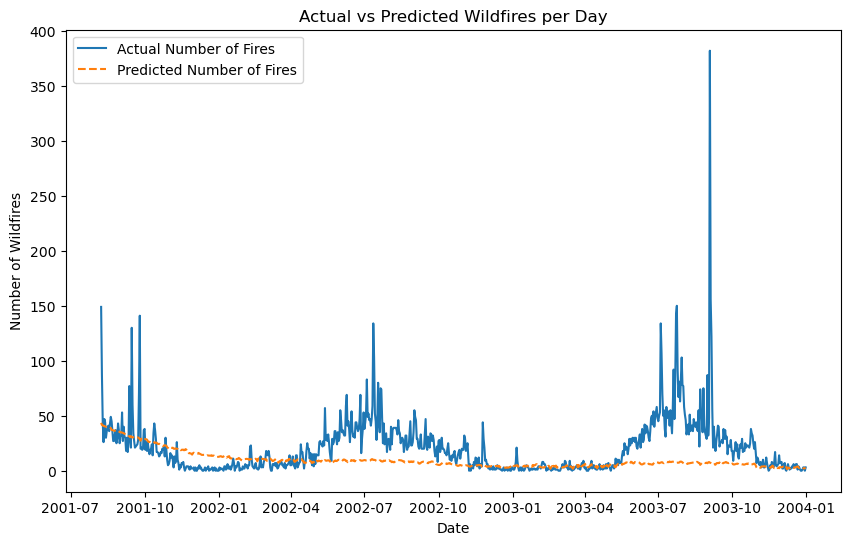

In [18]:
plt.figure(figsize=(10, 6))
plt.plot(y_test.index, y_test, label='Actual Number of Fires')
plt.plot(y_test.index, predictions, label='Predicted Number of Fires', linestyle='--')
plt.title('Actual vs Predicted Wildfires per Day')
plt.xlabel('Date')
plt.ylabel('Number of Wildfires')
plt.legend()

### Automatically find the best ARIMA parameters

In [19]:
auto_model = auto_arima(y_train, exogenous=X_train, seasonal=False, trace=True, suppress_warnings=True)
auto_model.summary()

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=28364.228, Time=0.98 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=34726.590, Time=0.07 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=28927.761, Time=0.19 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=32071.974, Time=0.67 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=28443.900, Time=1.47 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=28363.123, Time=2.42 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=28662.764, Time=0.90 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=28778.626, Time=0.44 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=28364.192, Time=2.38 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=28671.830, Time=0.67 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=28366.992, Time=2.14 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=28356.776, Time=3.85 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=28608.134, Time=1.82 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=28681.358, Time=0.94 sec
 ARIMA(3,0,1)(0,0,0

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 3507
Model:               SARIMAX(2, 0, 1)   Log Likelihood              -14173.388
Date:                Sat, 21 Sep 2024   AIC                          28356.776
Time:                        23:37:11   BIC                          28387.589
Sample:                    01-01-1992   HQIC                         28367.772
                         - 08-07-2001                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1011      0.083      1.215      0.224      -0.062       0.264
ar.L1          1.4610      0.009    167.422      0.000       1.444       1.478
ar.L2         -0.4655      0.008    -57.990      0.000      -0.481      -0.450
ma.L1         -0.8937      0.008   -107.672      0.000      -0.910      -0.877
sigma2       189.5254      0.973    194.796      0.000     187.618     191.432
===================================================================================
Ljung-Box (L1) (Q):                   0.19   Jarque-Bera (JB):           1156171.78
Prob(Q):                              0.66   Prob(JB):                         0.00
Heteroskedasticity (H):               0.85   Skew:                             5.67
Prob(H) (two-sided):                  0.00   Kurtosis:                        91.22
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

#### Fit the Model with the Selected Parameters

In [20]:
p, d, q = auto_model.order

# Fit the model using the best parameters and exogenous variables
auto_arimax_model = SARIMAX(y_train, exog=X_train, order=(p, d, q))
auto_model_fit = auto_arimax_model.fit()

auto_model_fit.summary()

C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:          NumberOfFires   No. Observations:                 3507
Model:               SARIMAX(2, 0, 1)   Log Likelihood              -14175.046
Date:                Sat, 21 Sep 2024   AIC                          28360.093
Time:                        23:37:16   BIC                          28390.905
Sample:                    01-01-1992   HQIC                         28371.088
                         - 08-07-2001                                         
Covariance Type:                  opg                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
MaxTemperature     0.1768      0.092      1.928      0.054      -0.003       0.357
ar.L1              1.4626      0.008    186.932      0.000       1.447       1.478
ar.L2             -0.4650      0.008    -61.358      0.000      -0.480      -0.450
ma.L1             -0.9007      0.007   -124.725      0.000      -0.915      -0.887
sigma2           189.6801      1.012    187.357      0.000     187.696     191.664
===================================================================================
Ljung-Box (L1) (Q):                   0.15   Jarque-Bera (JB):           1147562.45
Prob(Q):                              0.70   Prob(JB):                         0.00
Heteroskedasticity (H):               0.85   Skew:                             5.63
Prob(H) (two-sided):                  0.00   Kurtosis:                        90.90
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

#### Make Predictions and Evaluate the Model on the Test Data

In [21]:
# Make predictions on the test data
auto_predictions = auto_model_fit.predict(start=len(y_train), end=len(y_train) + len(y_test) - 1, exog=X_test)

# Calculate the RMSE (Root Mean Squared Error)
auto_rmse = mean_squared_error(y_test, auto_predictions, squared=False)
print(f'Automatic ARIMA Model RMSE: {auto_rmse}')

Automatic ARIMA Model RMSE: 27.269445110260325


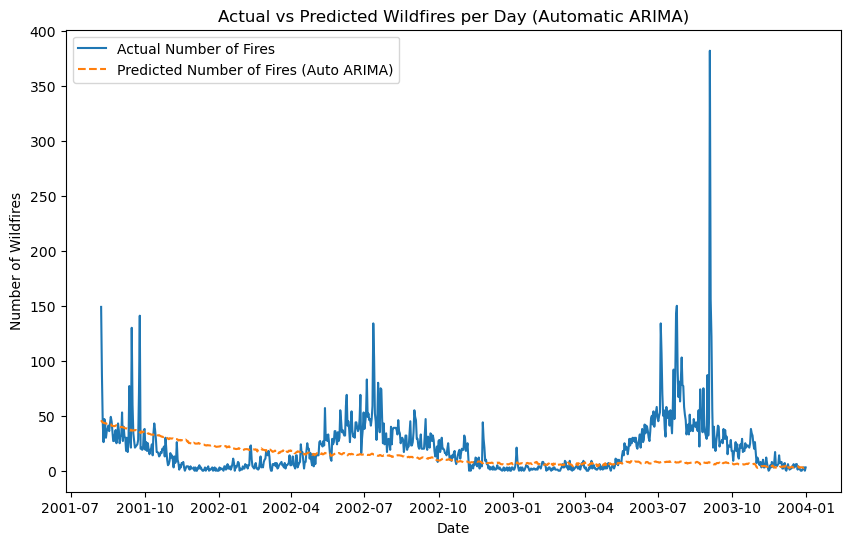

In [22]:
plt.figure(figsize=(10, 6))
plt.plot(y_test.index, y_test, label='Actual Number of Fires')
plt.plot(y_test.index, auto_predictions, label='Predicted Number of Fires (Auto ARIMA)', linestyle='--')
plt.title('Actual vs Predicted Wildfires per Day (Automatic ARIMA)')
plt.xlabel('Date')
plt.ylabel('Number of Wildfires')
plt.legend()

### SARIMAX model for seasonality

In [23]:
# Run auto_arima with seasonality
# auto_model_sarima = auto_arima(y_train, 
#     exogenous=X_train, 
#     seasonal=True, 
#     m=30,  
#     maxiter=20, 
#     max_p=3, max_q=3, 
#     max_P=2, max_Q=2, 
#     trace=True, 
#     suppress_warnings=True)

# auto_model_sarima.summary()

In [24]:
# Make predictions on the test data using the trained SARIMAX model
# sarimax_predictions = auto_model_sarima.predict(
#     start=y_train.shape[0], 
#     end=y_train.shape[0] + y_test.shape[0] - 1, 
#     exogenous=X_test, 
#     dynamic=False  
# )

# # Check the lengths of y_test and sarimax_predictions
# print(f'Length of y_test: {len(y_test)}')
# print(f'Length of sarimax_predictions: {len(sarimax_predictions)}')
# print(f'Length of X_test: {len(X_test)}')
# print(f'Length of y_train: {len(y_train)}')
# print(y_train.shape[0] + y_test.shape[0] - 1)


# Now calculate the RMSE after ensuring consistent lengths
# sarimax_rmse = mean_squared_error(y_test, sarimax_predictions, squared=False)
# print(f'Root Mean Squared Error (RMSE) for SARIMAX: {sarimax_rmse}')


In [25]:
# Visualize the Actual vs. Predicted Value
# plt.figure(figsize=(10, 6))
# plt.plot(y_test.index, y_test, label='Actual Number of Fires')
# plt.plot(y_test.index, sarimax_predictions, label='Predicted Number of Fires (SARIMAX)', linestyle='--')
# plt.title('Actual vs Predicted Wildfires per Day (SARIMAX)')
# plt.xlabel('Date')
# plt.ylabel('Number of Wildfires')
# plt.legend()

In [26]:
# auto_model_sarima = auto_arima(
#     y_train, 
#     exogenous=None, 
#     seasonal=True, 
#     m=365, 
#     maxiter=10, 
#     max_p=2, max_q=2, 
#     max_P=1, max_Q=1, 
#     trace=True, 
#     stepwise=True,
#     suppress_warnings=True
# )

# auto_model_sarima.summary()

In [ ]:
# Manually set ARIMA and seasonal parameters (you can tweak these values)
model = SARIMAX(
    y_train, 
    order=(2, 0, 2),  # ARIMA parameters (p, d, q)
    seasonal_order=(1, 0, 1, 365)  # Seasonal ARIMA parameters (P, D, Q, m)
)

# Fit the SARIMAX model
sarimax_manual = model.fit(disp=False)

# Make predictions
sarimax_predictions_manual = sarimax_manual.predict(
    start=len(y_train), 
    end=len(y_train) + len(y_test) - 1
)

print(sarimax_manual.summary())